In [27]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
import numpy as np

# Classification of Images of Handwritten 0 and 1

## Dataset

MNIST data

Image size is 28 x 28 pixcels. Each pixcel is a feature. Therefore total number of features is 784.

In [28]:
image_size = 28 # width and length are equal
data_path = "./dataset/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

In [29]:
print("Number of training datapoints: {}".format(train_data.shape[0]))
print("Number of testing datapoints: {}".format(test_data.shape[0]))

Number of training datapoints: 60000
Number of testing datapoints: 10000


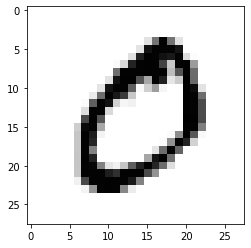

In [30]:
img = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(img, cmap="Greys")
plt.show()

In [32]:
img.shape

(28, 28)

## Dimensionality Reduction

Dimensionality reduction finds a lower number of variables or removes the least important variables from the model. That will reduce the model's complexity and also remove some noise in the data. In this way, dimensionality reduction helps to mitigate overfitting.

In [31]:
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [33]:
X_SVD.shape

(10000, 10)

In [34]:
train_data_features_reduced.shape

(10000, 2)

In [35]:
# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

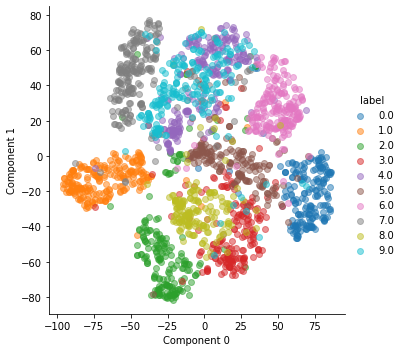

In [36]:
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

In [8]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append([train_data_features_reduced[i]])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append([train_data_features_reduced[i]])
        
zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

## What are Feature Maps?

Classical data needs to be mapped to Hilbert Space for Quantum operators to be able to operate on them. Feature maps encodes classical data into quantum state. Due to this classical data is now represented in a higher dimensional space. VQCs are linear classifiers in higher dimensional space

### Qiksit Feature Maps

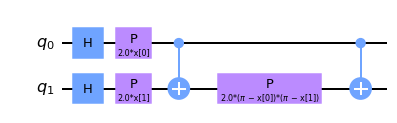

In [9]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1)#, paulis = ['Z','X','ZY'])
pauli_feature_map.decompose().draw("mpl")

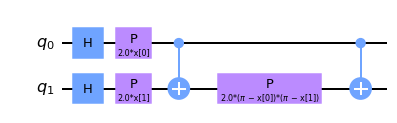

In [10]:
feature_dim = 2
pauli_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1)
pauli_feature_map.decompose().draw("mpl")

## Variational Circuits

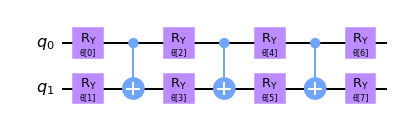

In [11]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
variational_circ.decompose().draw("mpl")

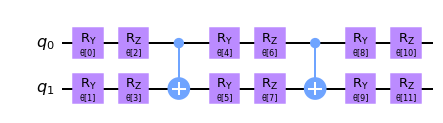

In [12]:
var_circuit = EfficientSU2(feature_dim, reps=2)
var_circuit.decompose().draw("mpl")

The first question you must ask when looking for an ansatz is: Can the trial state prepared by my ansatz circuit encode my solution? For example: Does your solution contain complex amplitudes? If yes, you need a circuit that contains complex amplitudes (such as EfficientSU2). If no, you could use one that has only real amplitudes (such as RealAmplitudes).

In [13]:
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

In [14]:
#Train data
train_data = []
for i in range(train_size):
    train_data.append(np.append(zero_train[i], [0]))
for i in range(train_size):
    train_data.append(np.append(one_train[i], [1]))
np.random.shuffle(train_data)
    
final_data = []
lables = []
for point in train_data:
    final_data.append(point[:-1])
    lables.append(point[-1])
    
##Test data
test_data = []
for i in range(test_size):
    test_data.append(np.append(zero_test[i], [0]))
for i in range(test_size):
    test_data.append(np.append(one_test[i], [1]))
np.random.shuffle(test_data)
    
final_data_test = []
lables_test = []
for point in test_data:
    final_data_test.append(point[:-1])
    lables_test.append(point[-1])

In [15]:
final_data

[array([1.84043837, 0.90651381]),
 array([1.78988743, 0.98963034]),
 array([1.67325735, 0.87726164]),
 array([1.54321527, 0.76310277]),
 array([1.71123147, 0.69664192]),
 array([1.75109613, 0.67647088]),
 array([0.50442195, 0.96638751]),
 array([1.78372002, 0.78603035]),
 array([1.75244904, 0.66206855]),
 array([1.85295415, 0.82131535]),
 array([1.75467086, 0.65360701]),
 array([0.57244885, 0.96623284]),
 array([0.19236511, 0.80182689]),
 array([0.22353178, 0.80870295]),
 array([0.56678092, 0.99088651]),
 array([1.83085179, 0.77870661]),
 array([1.6047914 , 0.74710238]),
 array([0.19388342, 0.92912388]),
 array([0.41495615, 0.98049575]),
 array([0.44182336, 0.89482278]),
 array([0.20676732, 0.83588672]),
 array([1.52988505, 0.70979619]),
 array([1.77494264, 0.98125887]),
 array([0.09373778, 0.79999387]),
 array([1.62733614, 0.60322827]),
 array([0.54168689, 0.55242145]),
 array([0.45824093, 0.93384457]),
 array([1.80755424, 0.71805489]),
 array([0.38904321, 0.99682444]),
 array([0.6140

In [16]:
lables

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0]

In [17]:
seed = 10598
feature_dim = np.array(final_data).shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='linear')
feature_map.draw()

┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘

In [18]:
from  qiskit.algorithms.optimizers import COBYLA
cobyla = COBYLA(maxiter=500, tol=0.001)

The first question you must ask when looking for an ansatz is: Can the trial state prepared by my ansatz circuit encode my solution? For example: Does your solution contain complex amplitudes? If yes, you need a circuit that contains complex amplitudes (such as EfficientSU2). If no, you could use one that has only real amplitudes (such as RealAmplitudes).

In [19]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var_circuit = EfficientSU2(2, reps=1)

In [20]:
var_circuit.draw()

┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                       ├
     └────────────────────────────────────────────────────────┘

In [21]:
from IPython.display import clear_output
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [22]:
# initilizing backend
seed = 10598
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}
from qiskit_machine_learning.algorithms.classifiers import neural_network_classifier
from qiskit_machine_learning.algorithms import VQC
# creating a quantum instance
from qiskit.utils.quantum_instance import QuantumInstance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

#initilizing VQC object
vqc = VQC(num_qubits=2, feature_map=feature_map, ansatz=var_circuit, loss='cross_entropy', optimizer=cobyla,quantum_instance=quantum_instance, callback = callback_graph)

/tmp/ipykernel_12382/599099689.py:12: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(num_qubits=2, feature_map=feature_map, ansatz=var_circuit, loss='cross_entropy', optimizer=cobyla,quantum_instance=quantum_instance, callback = callback_graph)


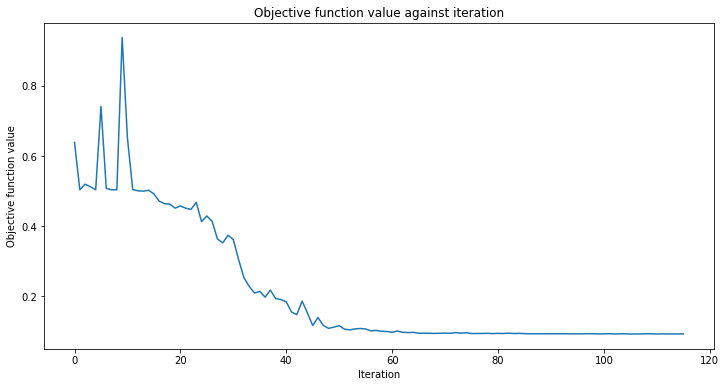

0.975

In [23]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(np.array(final_data), np.array(lables))

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(np.array(final_data), np.array(lables))

In [24]:
test_data = []
for i in range(test_size):
    test_data.append(np.append(zero_test[i], [0]))
for i in range(test_size):
    test_data.append(np.append(one_test[i], [1]))
np.random.shuffle(test_data)
    
final_data_test = []
lables_test = []
for point in test_data:
    final_data_test.append(point[:-1])
    lables_test.append(point[-1])

In [25]:
test_score_q4 = vqc.score(np.array(final_data_test), np.array(lables_test))
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the test dataset:     0.95
